# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from econml.dr import DRLearner
from econml.dml import CausalForestDML

# Data Loading

In [2]:
# ===============================
# 1. Import & Basic Setup
# ===============================

# Load dataset
df = pd.read_csv("dummy_causal_inference_indonesia.csv", sep=";")
df.columns = df.columns.str.lower()

# Format kolom date
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

print("Shape dataset:", df.shape)

Shape dataset: (10000, 16)


In [3]:
# ===============================
# 2. Data Cleaning
# ===============================
df_clean = df.copy()

# Spending negatif → set jadi 0
df_clean["spending"] = df_clean["spending"].apply(lambda x: 0 if x < 0 else x)

# Cek missing values
print("Missing values per kolom:")
print(df_clean.isnull().sum())

Missing values per kolom:
customerid            0
income                0
age                   0
gender                0
maritalstatus         0
city                  0
date                  0
period                0
treatment_campaign    0
spending              0
webpurchases          0
storepurchases        0
catalogpurchases      0
mntfood               0
mntfashion            0
mntelectronics        0
dtype: int64


In [4]:
# Encoding categorical
categorical_cols = ["gender", "maritalstatus", "city", "period"]
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

In [5]:
# Confounders
treatment = "treatment_campaign"
outcome = "spending"

numeric_conf = ["income", "age", "webpurchases", "storepurchases", 
                "catalogpurchases", "mntfood", "mntfashion", "mntelectronics"]
cat_conf = [col for col in df_encoded.columns if col.startswith(tuple(categorical_cols))]

confounders = numeric_conf + cat_conf

In [6]:
# Scaling numeric confounders
scaler = StandardScaler()
df_encoded[numeric_conf] = scaler.fit_transform(df_encoded[numeric_conf])

print("Jumlah confounders:", len(confounders))

Jumlah confounders: 18


# Exploratory Data Analysis

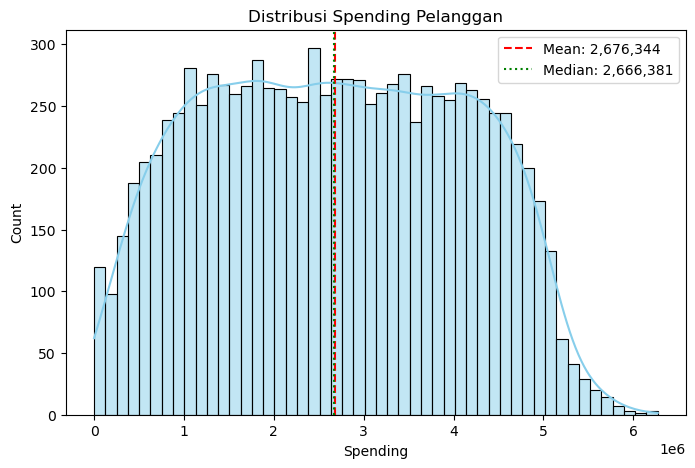

In [7]:
# ===============================
# 3. EDA
# ===============================

# Distribusi Spending
plt.figure(figsize=(8,5))
sns.histplot(df_encoded["spending"], bins=50, kde=True, color="skyblue")
plt.axvline(df_encoded["spending"].mean(), color="red", linestyle="--", label=f"Mean: {df_encoded['spending'].mean():,.0f}")
plt.axvline(df_encoded["spending"].median(), color="green", linestyle=":", label=f"Median: {df_encoded['spending'].median():,.0f}")
plt.title("Distribusi Spending Pelanggan")
plt.xlabel("Spending")
plt.legend()
plt.show()

C:\Users\luthf\AppData\Local\Temp\ipykernel_9844\1221697850.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=treatment, data=df_encoded, palette="Set2")


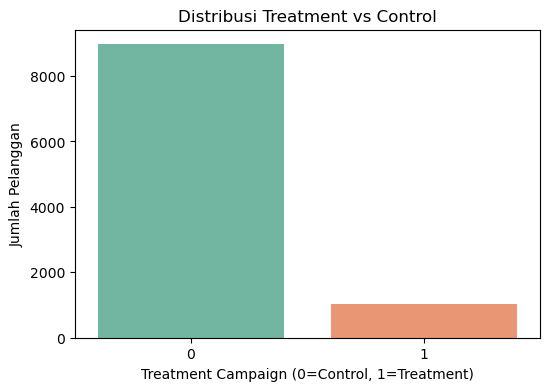

Distribusi Treatment (%):
treatment_campaign
0    89.67
1    10.33
Name: proportion, dtype: float64


In [8]:
# Distribusi Treatment
plt.figure(figsize=(6,4))
sns.countplot(x=treatment, data=df_encoded, palette="Set2")
plt.title("Distribusi Treatment vs Control")
plt.xlabel("Treatment Campaign (0=Control, 1=Treatment)")
plt.ylabel("Jumlah Pelanggan")
plt.show()

print("Distribusi Treatment (%):")
print(df_encoded[treatment].value_counts(normalize=True) * 100)

C:\Users\luthf\AppData\Local\Temp\ipykernel_9844\3543225836.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=treatment, y=outcome, data=df_encoded, palette="Set2")


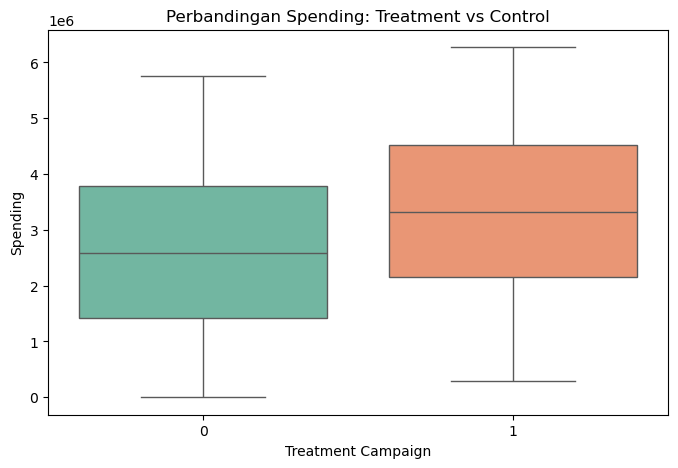

Rata-rata Spending per Group:
treatment_campaign
0    2.601433e+06
1    3.326607e+06
Name: spending, dtype: float64


In [9]:
# Spending per Group (Treatment vs Control)
plt.figure(figsize=(8,5))
sns.boxplot(x=treatment, y=outcome, data=df_encoded, palette="Set2")
plt.title("Perbandingan Spending: Treatment vs Control")
plt.xlabel("Treatment Campaign")
plt.ylabel("Spending")
plt.show()

print("Rata-rata Spending per Group:")
print(df_encoded.groupby(treatment)[outcome].mean())

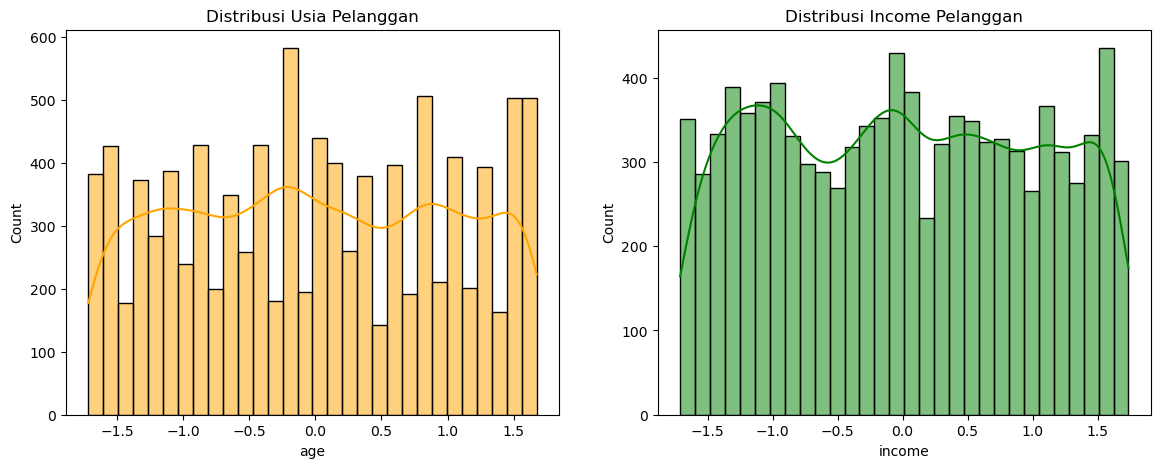

In [10]:
# Distribusi Confounders
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(df_encoded["age"], bins=30, kde=True, ax=axes[0], color="orange")
axes[0].set_title("Distribusi Usia Pelanggan")
sns.histplot(df_encoded["income"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribusi Income Pelanggan")
plt.show()

C:\Users\luthf\AppData\Local\Temp\ipykernel_9844\1163213014.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="treatment_campaign", y="age", data=df_encoded, ax=axes[0], palette="Set2")
C:\Users\luthf\AppData\Local\Temp\ipykernel_9844\1163213014.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="treatment_campaign", y="income", data=df_encoded, ax=axes[1], palette="Set2")


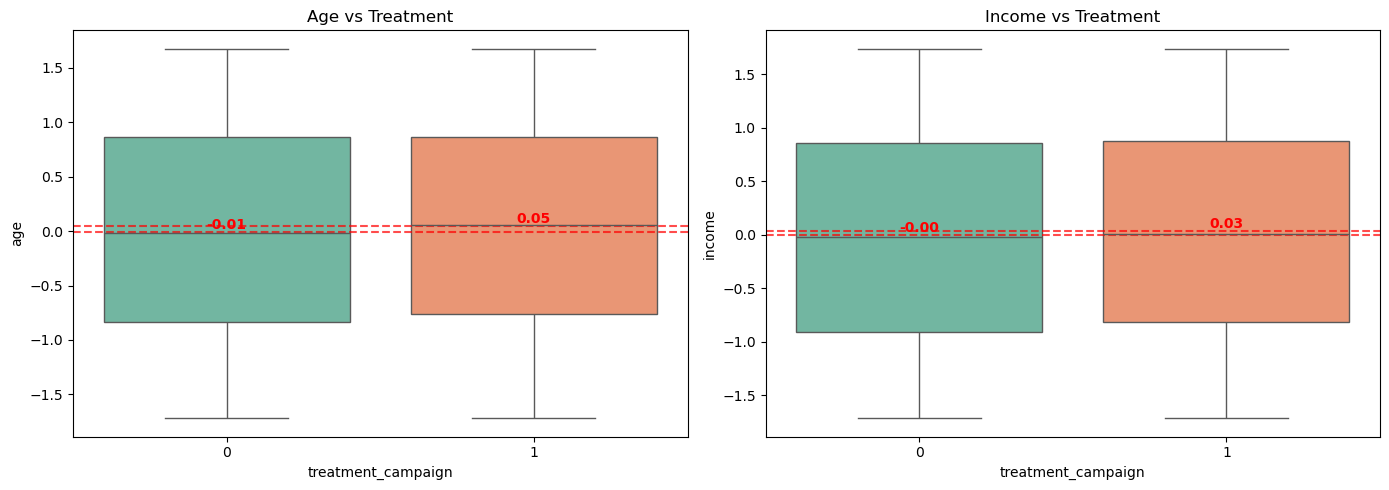

In [11]:
# Confounder vs Treatment
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Boxplot Age
sns.boxplot(x="treatment_campaign", y="age", data=df_encoded, ax=axes[0], palette="Set2")
axes[0].set_title("Age vs Treatment")

# Boxplot Income
sns.boxplot(x="treatment_campaign", y="income", data=df_encoded, ax=axes[1], palette="Set2")
axes[1].set_title("Income vs Treatment")

# Tambahkan garis mean dan anotasi
for ax, col in zip(axes, ["age", "income"]):
    means = df_encoded.groupby("treatment_campaign")[col].mean()
    for xpos, val in enumerate(means):
        # garis horizontal mean
        ax.axhline(val, color="red", linestyle="--", alpha=0.7)
        # teks nilai mean
        ax.text(xpos, val, f"{val:.2f}", ha="center", va="bottom", 
                color="red", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

In [12]:
# T-test Age & Income
control_age = df_encoded[df_encoded[treatment] == 0]["age"]
treatment_age = df_encoded[df_encoded[treatment] == 1]["age"]
t_stat, p_val = ttest_ind(control_age, treatment_age)
print(f"T-test Age Control vs Treatment: t={t_stat:.2f}, p={p_val:.4f}")

control_income = df_encoded[df_encoded[treatment] == 0]["income"]
treatment_income = df_encoded[df_encoded[treatment] == 1]["income"]
t_stat, p_val = ttest_ind(control_income, treatment_income)
print(f"T-test Income Control vs Treatment: t={t_stat:.2f}, p={p_val:.4f}")

T-test Age Control vs Treatment: t=-1.64, p=0.1015
T-test Income Control vs Treatment: t=-1.11, p=0.2660


# Casual Inference Modeling

Propensity Score Matching (PSM) ATE: 716,927


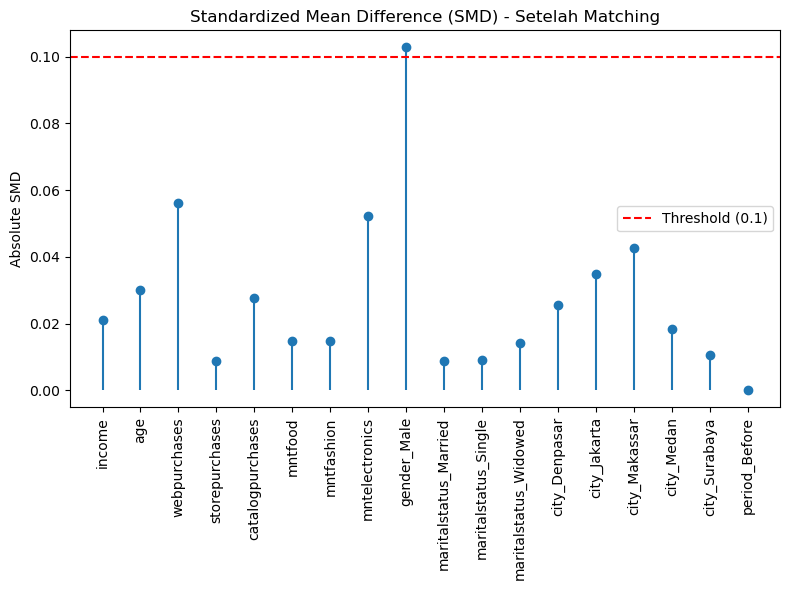


SMD setelah matching (seharusnya semua di bawah 0.1):
income              0.021090
age                 0.030057
webpurchases        0.056234
storepurchases      0.008688
catalogpurchases    0.027523
dtype: float64


In [13]:
# ===============================================
# 4. Causal Inference - Propensity Score Matching
# ===============================================

# --- Define calculate_smd function ---
def calculate_smd(df, treatment_var, confounders):
    """
    Calculate Standardized Mean Difference (SMD) for confounders between treatment groups
    """
    treated = df[df[treatment_var] == 1]
    control = df[df[treatment_var] == 0]
    
    smd_results = {}
    
    for covariate in confounders:
        mean_treated = treated[covariate].mean()
        mean_control = control[covariate].mean()
        std_treated = treated[covariate].std()
        std_control = control[covariate].std()
        
        # Pooled standard deviation
        pooled_std = np.sqrt((std_treated**2 + std_control**2) / 2)
        
        # Avoid division by zero
        if pooled_std == 0:
            smd = 0
        else:
            smd = abs(mean_treated - mean_control) / pooled_std
        
        smd_results[covariate] = smd
    
    return pd.Series(smd_results)

# --- Model Propensity Score ---
X = df_encoded[confounders]
T = df_encoded[treatment]
Y = df_encoded[outcome]

ps_model = LogisticRegression(max_iter=2000, solver='lbfgs')
ps_model.fit(X, T)
propensity_scores = ps_model.predict_proba(X)[:, 1]
df_encoded['propensity_score'] = propensity_scores

# --- Melakukan Matching (1-to-1 Nearest Neighbor) ---
treated_group = df_encoded[df_encoded[treatment] == 1]
control_group = df_encoded[df_encoded[treatment] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_group[['propensity_score']])
distances, indices = nn.kneighbors(treated_group[['propensity_score']])

matched_control_indices = indices.flatten()
matched_control_group = control_group.iloc[matched_control_indices]

# Gabungkan data yang sudah di-match
df_matched = pd.concat([treated_group, matched_control_group])

# --- Hitung ATE dari data yang sudah di-match ---
ate_psm = (df_matched[df_matched[treatment] == 1][outcome].mean() -
           df_matched[df_matched[treatment] == 0][outcome].mean())

print(f"Propensity Score Matching (PSM) ATE: {ate_psm:,.0f}")

# --- Periksa Keseimbangan SETELAH Matching ---
smd_after = calculate_smd(df_matched, treatment, confounders)

plt.figure(figsize=(8, 6))
plt.stem(smd_after.index, smd_after.values, basefmt=" ")
plt.axhline(0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.title('Standardized Mean Difference (SMD) - Setelah Matching')
plt.ylabel('Absolute SMD')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

print("\nSMD setelah matching (seharusnya semua di bawah 0.1):")
print(smd_after.head())

In [14]:
# ===============================
# 5. Causal Inference Modeling
# ===============================

# Variabel
X = df_encoded[confounders]
T = df_encoded[treatment]
Y = df_encoded[outcome]

# -----------------------------------------
# (1) Doubly Robust Learner
# -----------------------------------------
dr_learner = DRLearner(
    model_propensity=LogisticRegression(max_iter=2000, solver="lbfgs"),
    model_regression=RandomForestRegressor(n_estimators=100, random_state=42)
)

dr_learner.fit(Y, T, X=X)
ate_dr = dr_learner.ate(X)
print(f"Doubly Robust Learner (DR) ATE: {ate_dr:,.0f}")

Doubly Robust Learner (DR) ATE: 727,407


In [15]:
# -----------------------------------------
# (2) Causal Forest (ITE & CATE)
# -----------------------------------------
causal_forest = CausalForestDML(
    n_estimators=500,
    min_samples_leaf=10,
    random_state=42
)
causal_forest.fit(Y, T, X=X)

ite = causal_forest.effect(X)
ate_cf = np.mean(ite)
print(f"Causal Forest (mean ITE): {ate_cf:,.0f}")

Causal Forest (mean ITE): 726,079


In [16]:
# Segmentasi Income → High vs Low
income_median = df_encoded["income"].median()
df_encoded["income_group"] = np.where(df_encoded["income"] >= income_median, "High Income", "Low Income")

cate_income = (
    pd.DataFrame({"ITE": ite, "income_group": df_encoded["income_group"]})
    .groupby("income_group")
    .mean()
    .reset_index()
)
print("\nCATE per Income Group:")
print(cate_income)


CATE per Income Group:
  income_group            ITE
0  High Income  731931.347713
1   Low Income  720221.852601


In [17]:
# -----------------------------------------
# (3) Bayesian Regression
# -----------------------------------------
X_bayes = df_encoded[confounders].astype(float).values
T_bayes = df_encoded[treatment].astype(float).values
Y_bayes = df_encoded[outcome].astype(float).values

# Standarisasi outcome
Y_mean, Y_std = Y_bayes.mean(), Y_bayes.std()
Y_stdzd = (Y_bayes - Y_mean) / Y_std
X_all = np.column_stack([T_bayes, X_bayes]).astype(float)

with pm.Model() as bayes_model:
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    coefs = pm.Normal("coefs", mu=0, sigma=1, shape=X_all.shape[1])
    mu = intercept + pm.math.dot(X_all, coefs)
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_stdzd)
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
c:\Users\luthf\anaconda3\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefs, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.



Bayesian ATE (posterior mean): 727,515
95% Credible Interval: [620,935, 839,776]


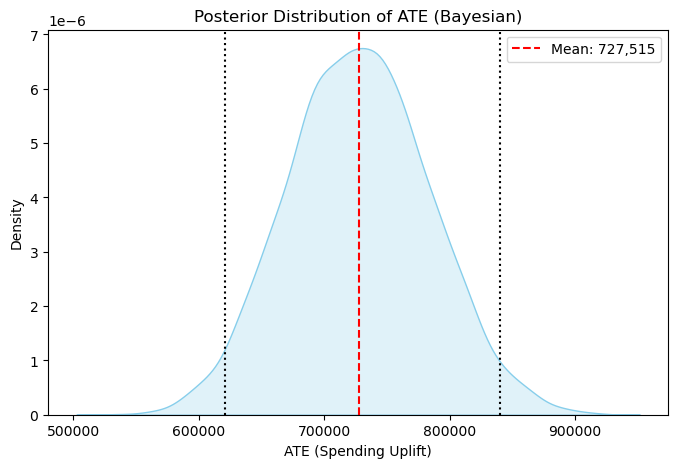

In [18]:
# Koefisien treatment = coefs[0]
ate_samples = trace.posterior["coefs"].sel(coefs_dim_0=0).values.flatten() * Y_std
ate_bayes = ate_samples.mean()
ate_ci = np.percentile(ate_samples, [2.5, 97.5])

print(f"\nBayesian ATE (posterior mean): {ate_bayes:,.0f}")
print(f"95% Credible Interval: [{ate_ci[0]:,.0f}, {ate_ci[1]:,.0f}]")

plt.figure(figsize=(8,5))
sns.kdeplot(ate_samples, fill=True, color="skyblue")
plt.axvline(ate_bayes, color="red", linestyle="--", label=f"Mean: {ate_bayes:,.0f}")
plt.axvline(ate_ci[0], color="black", linestyle=":")
plt.axvline(ate_ci[1], color="black", linestyle=":")
plt.title("Posterior Distribution of ATE (Bayesian)")
plt.xlabel("ATE (Spending Uplift)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [19]:
# ===============================================
# 6. Ringkasan & Rekomendasi
# ===============================================

results_dict = {
    "Propensity Score Matching": {"ATE": ate_psm, "Interval": "-"},
    "Doubly Robust Learner": {"ATE": ate_dr, "Interval": "-"},
    "Causal Forest (mean ITE)": {"ATE": ate_cf, "Interval": "-"},
    "Bayesian Regression": {"ATE": ate_bayes, "Interval": f"[{ate_ci[0]:,.0f}, {ate_ci[1]:,.0f}]"}
}

results_df = pd.DataFrame(results_dict).T
results_df["ATE"] = results_df["ATE"].apply(lambda x: f"Rp {x:,.0f}" if isinstance(x, (int, float)) else x)
results_df["Interval"] = results_df["Interval"].apply(lambda x: f"Rp {x}" if "Rp" not in x and x != "-" else x)


print("\nRingkasan ATE antar Metode:")
display(results_df)

# --- Business Insight (Sama seperti kode Anda, tapi lebih kuat) ---
print("\n📌 Business Insight Summary:")
print(f"- Semua metode (PSM, DR, Causal Forest, Bayesian) memberikan estimasi yang konsisten, menunjukkan bahwa campaign meningkatkan spending rata-rata sekitar {ate_psm:,.0f} - {ate_bayes:,.0f} per pelanggan.")
print(f"- Bayesian Regression memberikan rentang keyakinan 95% untuk kenaikan ini, yaitu antara Rp {ate_ci[0]:,.0f} dan Rp {ate_ci[1]:,.0f}.")
# ... (lanjutkan dengan insight CATE dari Causal Forest seperti yang sudah Anda lakukan) ...


Ringkasan ATE antar Metode:


,ATE,Interval
Propensity Score Matching,"Rp 716,927",-
Doubly Robust Learner,"Rp 727,407",-
Causal Forest (mean ITE),"Rp 726,079",-
Bayesian Regression,"Rp 727,515","Rp [620,935, 839,776]"



📌 Business Insight Summary:
- Semua metode (PSM, DR, Causal Forest, Bayesian) memberikan estimasi yang konsisten, menunjukkan bahwa campaign meningkatkan spending rata-rata sekitar 716,927 - 727,515 per pelanggan.
- Bayesian Regression memberikan rentang keyakinan 95% untuk kenaikan ini, yaitu antara Rp 620,935 dan Rp 839,776.


In [20]:
# Hitung Threshold
def calculate_threshold(campaign_cost, n_customers, roi_target=1.0):
    """
    Hitung threshold uplift minimum per customer.
    
    Parameters:
    -----------
    campaign_cost : int/float
        Total biaya campaign (Rp).
    n_customers : int
        Jumlah customer yang ditargetkan.
    roi_target : float
        Target ROI (default=1.0 → break-even).
    
    Returns:
    --------
    threshold (float): uplift minimal per customer (Rp).
    """
    # Biaya rata-rata per customer
    cost_per_customer = campaign_cost / n_customers
    
    # Threshold = biaya per customer * ROI target
    threshold = cost_per_customer * roi_target
    
    return threshold

# ===============================
# Contoh penggunaan
# ===============================

# Campaign cost Rp 2 Miliar, target 10.000 customer, ROI minimal 2.5
campaign_cost = 2_000_000_000
n_customers = 10_000
roi_target = 2.5

threshold_value = calculate_threshold(campaign_cost, n_customers, roi_target)
print(f"Threshold uplift minimal per customer = Rp {threshold_value:,.0f}")

Threshold uplift minimal per customer = Rp 500,000


Prediksi untuk Pelanggan Sampel:
{'Predicted ITE': 794791.8915608253, 'Status': 'On Target'}

Ringkasan Batch Scoring:
Status
On Target     92.16
Off Target     7.84
Name: proportion, dtype: float64


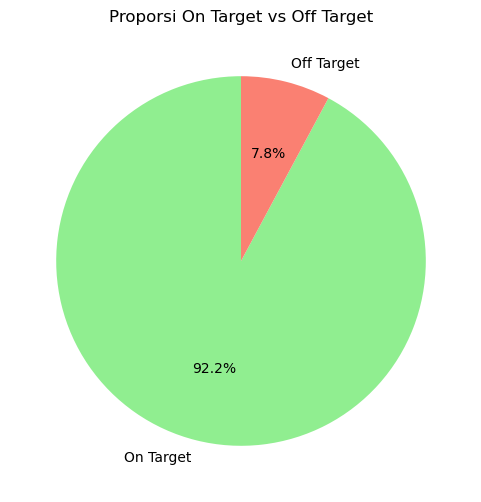

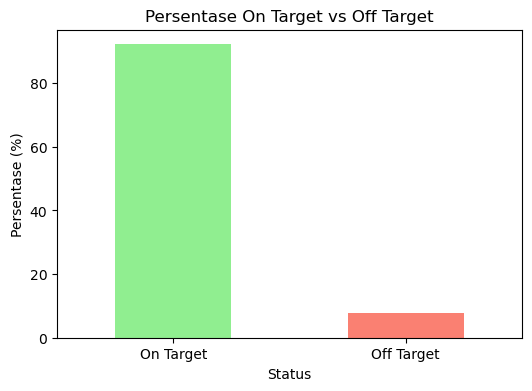

In [21]:
# ===============================
# 5. Lapisan Deployment (Versi Perbaikan)
# ===============================
# Tidak perlu import ulang library karena sudah diimpor di awal notebook

# --- Fungsi Prediksi untuk Satu Pelanggan Baru (Diperbaiki) ---
def predict_individual_uplift(causal_forest_model, scaler_object, customer_data_raw, threshold=0):
    """
    Memprediksi Individual Treatment Effect (ITE) untuk satu pelanggan baru 
    dan menentukan apakah target campaign tercapai.
    
    Fungsi ini memastikan data baru melewati proses preprocessing yang sama 
    (one-hot encoding dan scaling) seperti data training.
    
    Parameters:
    -----------
    causal_forest_model : model CausalForestDML yang sudah di-fit
    scaler_object : objek StandardScaler yang sudah di-fit pada data training
    customer_data_raw : dict berisi data mentah satu pelanggan
    threshold : float, nilai minimal ITE agar dianggap 'On Target'
    
    Returns:
    --------
    dict berisi 'Predicted ITE' dan 'Status'
    """
    
    # 1. Konversi data mentah (dict) ke DataFrame
    df_new = pd.DataFrame([customer_data_raw])
    
    # 2. Lakukan One-Hot Encoding
    df_new_encoded = pd.get_dummies(df_new, columns=categorical_cols, drop_first=True)
    
    # 3. Sejajarkan kolom agar sama persis dengan data training (X)
    # Ini penting agar tidak ada kolom yang hilang atau urutan yang salah
    # Kolom yang tidak ada di data baru akan diisi dengan 0
    df_new_aligned = df_new_encoded.reindex(columns=confounders, fill_value=0)
    
    # 4. Terapkan scaling HANYA pada kolom numerik, menggunakan scaler yang sudah ada
    # PENTING: Gunakan .transform(), bukan .fit_transform()
    df_new_aligned[numeric_conf] = scaler_object.transform(df_new_aligned[numeric_conf])
    
    # 5. Lakukan prediksi ITE
    ite_pred = causal_forest_model.effect(df_new_aligned)[0]
    
    # 6. Tentukan status berdasarkan threshold
    status = "On Target" if ite_pred > threshold else "Off Target"
    
    return {"Predicted ITE": ite_pred, "Status": status}


# --- Fungsi Batch Scoring (Kode Anda sudah benar, disertakan untuk kelengkapan) ---
def batch_predict_campaign_target(causal_forest, df_processed, threshold=0):
    """
    Memprediksi ITE untuk seluruh DataFrame yang sudah diproses.
    """
    ite_all = causal_forest.effect(df_processed[confounders])
    results = df_processed.copy()
    results["Predicted_ITE"] = ite_all
    results["Status"] = np.where(results["Predicted_ITE"] > threshold,
                                 "On Target", "Off Target")
    return results

# ===============================
# Contoh Penggunaan (Versi Perbaikan)
# ===============================

# Data mentah untuk satu pelanggan baru (sama seperti contoh Anda)
sample_customer_raw = {
    "income": 15000000, "age": 35, "webpurchases": 3, "storepurchases": 5,
    "catalogpurchases": 2, "mntfood": 1000000, "mntfashion": 1500000,
    "mntelectronics": 2000000, "gender": "Male", "maritalstatus": "Married",
    "city": "Jakarta", "period": "After" 
    # Pastikan semua kolom confounder mentah ada di sini
}

# Nilai threshold dari langkah sebelumnya
threshold_value = threshold_value 

# Panggil fungsi prediksi yang sudah diperbaiki
# Kita perlu memasukkan model, scaler, dan data mentah
result = predict_individual_uplift(causal_forest, scaler, sample_customer_raw, threshold=threshold_value)
print("Prediksi untuk Pelanggan Sampel:")
print(result)

# Contoh batch scoring tetap sama, karena menggunakan df_encoded yang sudah diproses
results_df = batch_predict_campaign_target(causal_forest, df_encoded, threshold=threshold_value)
print("\nRingkasan Batch Scoring:")
print(results_df["Status"].value_counts(normalize=True) * 100)

# Tambahkan dua baris ini untuk membuat variabel yang hilang
summary_counts = results_df["Status"].value_counts()
summary_perc = results_df["Status"].value_counts(normalize=True) * 100

# Visualisasi
plt.figure(figsize=(6,6))
plt.pie(summary_counts, labels=summary_counts.index, autopct='%1.1f%%',
        startangle=90, colors=["lightgreen", "salmon"])
plt.title("Proporsi On Target vs Off Target")
plt.show()

plt.figure(figsize=(6,4))
summary_perc.plot(kind="bar", color=["lightgreen", "salmon"])
plt.title("Persentase On Target vs Off Target")
plt.ylabel("Persentase (%)")
plt.xticks(rotation=0)
plt.show()

In [22]:
# ===============================
# 6. ROI Simulator
# ===============================
def roi_simulation(results_df, campaign_cost, threshold=0):
    """
    Hitung ROI campaign.
    ROI = (Total uplift spending - biaya campaign) / biaya campaign
    """
    uplift_total = results_df.loc[results_df["Predicted_ITE"] > threshold, "Predicted_ITE"].sum()
    roi = (uplift_total - campaign_cost) / campaign_cost
    return {"Total Uplift (Rp)": uplift_total, "ROI": roi}

# Contoh simulasi ROI
campaign_cost = 2_000_000_000  # contoh Rp 2 Miliar
roi_result = roi_simulation(results_df, campaign_cost, threshold=threshold_value)
print("\nROI Simulation Result:", roi_result)


ROI Simulation Result: {'Total Uplift (Rp)': 6921968349.769854, 'ROI': 2.460984174884927}


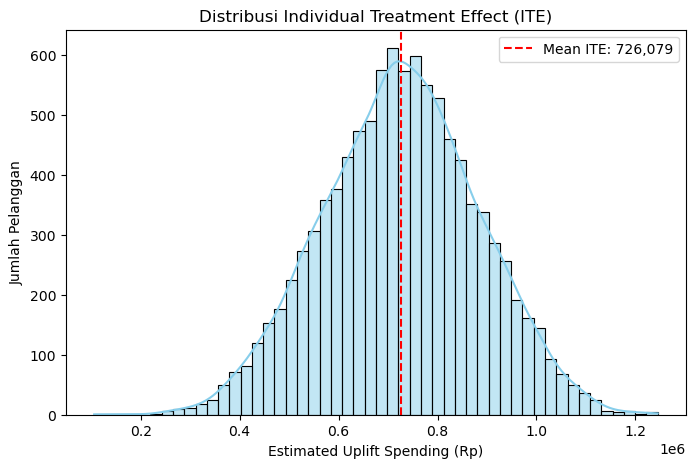

In [23]:
# ===============================
# 7. Evaluation & Business Insight
# ===============================

# ---- Distribusi ITE (Causal Forest) ----
plt.figure(figsize=(8,5))
sns.histplot(ite, bins=50, kde=True, color="skyblue")
plt.axvline(np.mean(ite), color="red", linestyle="--", label=f"Mean ITE: {np.mean(ite):,.0f}")
plt.title("Distribusi Individual Treatment Effect (ITE)")
plt.xlabel("Estimated Uplift Spending (Rp)")
plt.ylabel("Jumlah Pelanggan")
plt.legend()
plt.show()

C:\Users\luthf\AppData\Local\Temp\ipykernel_9844\1377406390.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\luthf\AppData\Local\Temp\ipykernel_9844\1377406390.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


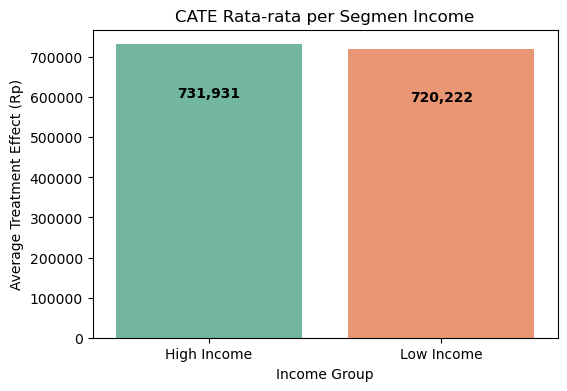

In [24]:
# ---- Segmen Income (CATE) ----
plt.figure(figsize=(6,4))
ax = sns.barplot(
    x="income_group", 
    y="ITE", 
    data=pd.DataFrame({"ITE": ite, "income_group": df_encoded["income_group"]}),
    palette="Set2", estimator=np.mean, ci=None
)

plt.title("CATE Rata-rata per Segmen Income")
plt.ylabel("Average Treatment Effect (Rp)")
plt.xlabel("Income Group")

# Tambahkan label di dalam bar
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value:,.0f}",
                (p.get_x() + p.get_width() / 2., value/1.2),  # posisi tengah bar
                ha="center", va="center", color="black", fontsize=10, fontweight="bold")

plt.show()

In [25]:
# ---- Ringkasan Naratif ----
print("\n📌 Business Insight Summary:")

print(f"- Doubly Robust Learner menunjukkan campaign meningkatkan spending rata-rata sekitar Rp {ate_dr:,.0f}.")
print(f"- Bayesian Regression memperkirakan uplift rata-rata Rp {ate_bayes:,.0f} dengan 95% Credible Interval [{ate_ci[0]:,.0f}, {ate_ci[1]:,.0f}].")
print(f"- Causal Forest menemukan heterogenitas: segmen High Income memiliki uplift lebih tinggi ({cate_income.loc[cate_income['income_group']=='High Income','ITE'].values[0]:,.0f}) dibanding Low Income ({cate_income.loc[cate_income['income_group']=='Low Income','ITE'].values[0]:,.0f}).")

print("\n💡 Rekomendasi untuk stakeholder:")
print("- Campaign efektif secara rata-rata, tetapi efek paling besar terjadi pada segmen High Income.")
print("- Untuk meningkatkan ROI, arahkan campaign ke pelanggan High Income terlebih dahulu.")
print("- Gunakan fungsi batch scoring untuk mengidentifikasi siapa saja pelanggan yang On Target.")



📌 Business Insight Summary:
- Doubly Robust Learner menunjukkan campaign meningkatkan spending rata-rata sekitar Rp 727,407.
- Bayesian Regression memperkirakan uplift rata-rata Rp 727,515 dengan 95% Credible Interval [620,935, 839,776].
- Causal Forest menemukan heterogenitas: segmen High Income memiliki uplift lebih tinggi (731,931) dibanding Low Income (720,222).

💡 Rekomendasi untuk stakeholder:
- Campaign efektif secara rata-rata, tetapi efek paling besar terjadi pada segmen High Income.
- Untuk meningkatkan ROI, arahkan campaign ke pelanggan High Income terlebih dahulu.
- Gunakan fungsi batch scoring untuk mengidentifikasi siapa saja pelanggan yang On Target.


# Inference

In [26]:
# ===============================
# 5. Lapisan Deployment (Versi Perbaikan)
# ===============================

# --- Fungsi Prediksi (Definisi fungsi Anda sudah benar, tidak perlu diubah) ---

def predict_individual_uplift(causal_forest_model, scaler_object, customer_data_raw, threshold=0):
    """Memprediksi ITE untuk satu pelanggan baru (input: dict)."""
    df_new = pd.DataFrame([customer_data_raw])
    df_new_encoded = pd.get_dummies(df_new, columns=categorical_cols, drop_first=True)
    df_new_aligned = df_new_encoded.reindex(columns=confounders, fill_value=0)
    df_new_aligned[numeric_conf] = scaler_object.transform(df_new_aligned[numeric_conf])
    ite_pred = causal_forest_model.effect(df_new_aligned)[0]
    status = "On Target" if ite_pred > threshold else "Off Target"
    return {"Predicted ITE": ite_pred, "Status": status}

def batch_predict_campaign_target(causal_forest, df_processed, threshold=0):
    """Memprediksi ITE untuk seluruh DataFrame yang sudah diproses."""
    ite_all = causal_forest.effect(df_processed[confounders])
    results = df_processed.copy()
    results["Predicted_ITE"] = ite_all
    results["Status"] = np.where(results["Predicted_ITE"] > threshold,
                                 "On Target", "Off Target")
    return results

# ===============================
# Contoh Penggunaan (Versi Perbaikan)
# ===============================

# 1. Buat DataFrame dengan 1000 data pelanggan mentah (unseen data)
# NOTE: Anda membuat kolom one-hot encoded secara langsung, jadi kita perlu menyesuaikannya
#       agar lebih realistis seperti data mentah asli.

n = 1000
np.random.seed(42) # Untuk hasil yang konsisten
genders = np.random.choice(["Male", "Female"], n)
marital_statuses = np.random.choice(["Single", "Married", "Widowed"], n)
cities = np.random.choice(["Jakarta", "Surabaya", "Denpasar", "Medan", "Makassar"], n)
periods = np.random.choice(["Before", "After"], n)


# DataFrame dengan data mentah (lebih realistis)
synthetic_data_raw = pd.DataFrame({
    "income": np.random.randint(3_000_000, 25_000_000, n),
    "age": np.random.randint(20, 60, n),
    "gender": genders,
    "maritalstatus": marital_statuses,
    "city": cities,
    "period": periods,
    "webpurchases": np.random.randint(0, 10, n),
    "storepurchases": np.random.randint(0, 10, n),
    "catalogpurchases": np.random.randint(0, 5, n),
    "mntfood": np.random.randint(100_000, 3_000_000, n),
    "mntfashion": np.random.randint(100_000, 3_000_000, n),
    "mntelectronics": np.random.randint(100_000, 3_000_000, n)
})

# 2. Lakukan Preprocessing pada data sintetis mentah
#    (Langkah ini WAJIB untuk menyamakan format dengan data training)
synthetic_encoded = pd.get_dummies(synthetic_data_raw, columns=categorical_cols, drop_first=True)
synthetic_aligned = synthetic_encoded.reindex(columns=confounders, fill_value=0)
synthetic_aligned[numeric_conf] = scaler.transform(synthetic_aligned[numeric_conf])

# Nilai threshold dari langkah sebelumnya
threshold_value = 500000 

# 3. Panggil fungsi BATCH PREDICT dengan data yang sudah diproses
results_synthetic_df = batch_predict_campaign_target(causal_forest, synthetic_aligned, threshold=threshold_value)

# 4. Tampilkan Hasil
print("Ringkasan Batch Scoring untuk 1000 Pelanggan Baru:")
print(results_synthetic_df["Status"].value_counts(normalize=True) * 100)

print("\nContoh 5 pelanggan baru dengan hasil prediksinya:")
# Gabungkan data mentah dengan hasil prediksi untuk interpretasi yang lebih mudah
display(pd.concat([
    synthetic_data_raw.head(5), 
    results_synthetic_df[['Predicted_ITE', 'Status']].head(5)
], axis=1))

Ringkasan Batch Scoring untuk 1000 Pelanggan Baru:
Status
On Target     94.4
Off Target     5.6
Name: proportion, dtype: float64

Contoh 5 pelanggan baru dengan hasil prediksinya:


,income,age,gender,maritalstatus,city,period,webpurchases,storepurchases,catalogpurchases,mntfood,mntfashion,mntelectronics,Predicted_ITE,Status
0,16784612,42,Male,Married,Medan,Before,2,0,3,2076230,2384319,677158,937104.972226,On Target
1,14999401,32,Female,Widowed,Makassar,Before,8,3,1,872783,1999955,2888647,881091.332955,On Target
2,9299492,51,Male,Single,Makassar,After,4,6,1,2309375,1628914,2130594,537878.313170,On Target
3,8928643,42,Male,Single,Jakarta,Before,2,8,0,1719800,2005888,2284080,253682.838670,Off Target
4,14469585,36,Male,Single,Surabaya,After,4,4,4,1026097,104507,1670497,791515.407719,On Target


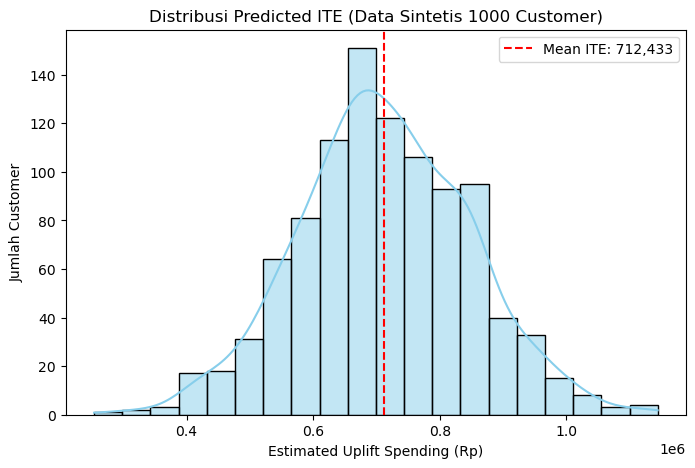

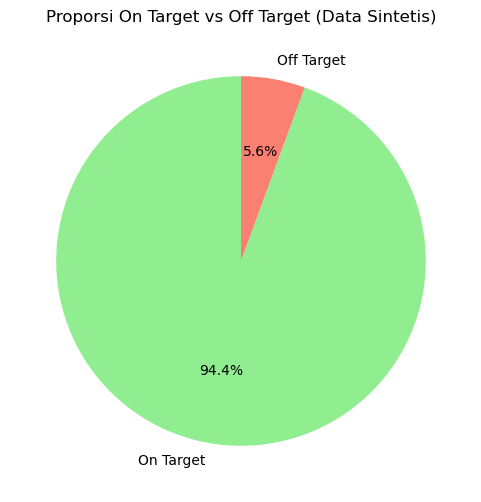

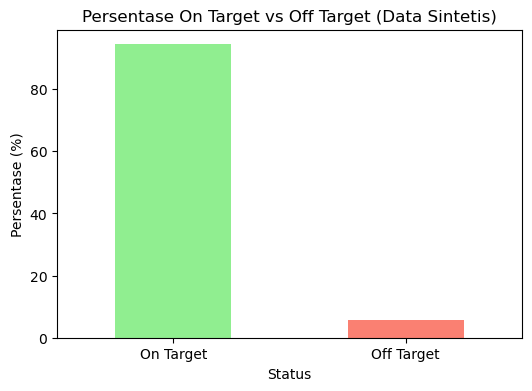

In [27]:
# ===============================
# Visualisasi Hasil Prediksi pada Data Sintetis
# ===============================

# 1. Histogram Predicted ITE (Individual Treatment Effect)
plt.figure(figsize=(8,5))
sns.histplot(results_synthetic_df["Predicted_ITE"], bins=20, kde=True, color="skyblue")
plt.axvline(results_synthetic_df["Predicted_ITE"].mean(), color="red", linestyle="--",
            label=f"Mean ITE: {results_synthetic_df['Predicted_ITE'].mean():,.0f}")
plt.title("Distribusi Predicted ITE (Data Sintetis 1000 Customer)")
plt.xlabel("Estimated Uplift Spending (Rp)")
plt.ylabel("Jumlah Customer")
plt.legend()
plt.show()

# ---

# 2. Pie chart On vs Off Target
summary_counts = results_synthetic_df["Status"].value_counts()

# Memastikan urutan warna konsisten (On Target hijau, Off Target merah)
colors = ['lightgreen' if label == 'On Target' else 'salmon' for label in summary_counts.index]

plt.figure(figsize=(6,6))
plt.pie(summary_counts, labels=summary_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors)
plt.title("Proporsi On Target vs Off Target (Data Sintetis)")
plt.show()

# ---

# 3. Bar chart On vs Off Target
summary_perc = results_synthetic_df["Status"].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))

# Menggunakan urutan dan warna yang sama
summary_perc.plot(kind="bar", color=colors)

plt.title("Persentase On Target vs Off Target (Data Sintetis)")
plt.ylabel("Persentase (%)")
plt.xticks(rotation=0)
plt.show()

# Model Saving

In [29]:
# ===============================
# 10. Save Model & Metadata
# ===============================
import joblib
import json
import os

os.makedirs("models", exist_ok=True)

# Simpan perhitungan ROI
joblib.dump(df_encoded, "models/df_encoded.pkl")

# Simpan model Causal Forest
joblib.dump(causal_forest, "models/causal_forest.pkl")

# Simpan model DR Learner
joblib.dump(dr_learner, "models/dr_learner.pkl")

# Simpan scaler
joblib.dump(scaler, "models/scaler.pkl")

# Simpan metadata (confounders, categorical_cols, threshold)
metadata = {
    "confounders": confounders,
    "numeric_conf": numeric_conf,
    "categorical_cols": categorical_cols,
    "threshold_value": threshold_value
}

with open("models/metadata.json", "w") as f:
    json.dump(metadata, f)

print("✅ Model, scaler, dan metadata berhasil disimpan ke folder 'models/'")

✅ Model, scaler, dan metadata berhasil disimpan ke folder 'models/'
